In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import time
import tensorflow as tf
from random import shuffle
import glob

/usr/local/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['STFangsong']
mpl.rcParams['figure.figsize'] = (20, 3)

In [6]:
%matplotlib inline

In [7]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

from object_detection.utils import ops as utils_ops

In [8]:
from numbers import Real
def to_severity(lesions_num:Real) -> int:
    """
    The Hayashi criterion
    The appropriate divisions of inflammatory eruptions of half of the face to decide classifications were:     0-5, "mild";
        6-20, "moderate";
        21-50, "severe";
        >=50, "very severe"
    Reference:
    [1] Hayashi N, Akamatsu H, Kawashima M, et al. Establishment of grading criteria for acne severity[J]. The Journal of dermatology, 2008, 35(5): 255-260.
    [2] https://www.ncbi.nlm.nih.gov/pubmed/18477223
    """
    if lesions_num <= 5:
        return 0
    elif lesions_num <= 20:
        return 1
    elif lesions_num <= 50:
        return 2
    else:
        return 3

def nms_cpu(boxes, confs, nms_thresh=0.5, min_mode=False):
    # print(boxes.shape)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = confs.argsort()[::-1]

    keep = []
    while order.size > 0:
        idx_self = order[0]
        idx_other = order[1:]

        keep.append(idx_self)

        xx1 = np.maximum(x1[idx_self], x1[idx_other])
        yy1 = np.maximum(y1[idx_self], y1[idx_other])
        xx2 = np.minimum(x2[idx_self], x2[idx_other])
        yy2 = np.minimum(y2[idx_self], y2[idx_other])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h

        if min_mode:
            over = inter / np.minimum(areas[order[0]], areas[order[1:]])
        else:
            over = inter / (areas[order[0]] + areas[order[1:]] - inter)

        inds = np.where(over <= nms_thresh)[0]
        order = order[inds + 1]
    
    return np.array(keep)

In [9]:
parent_dir = "/export/servers/wenhao/acne_detection_new/faster_rcnn_resnet101/latest_models/"

In [10]:
faster_rcnn_resnet101_large_frozen_graph = os.path.join(parent_dir, "faster_rcnn_resnet101_latest/frozen_inference_graph.pb")

In [11]:
PATH_TO_FROZEN_GRAPH = faster_rcnn_resnet101_large_frozen_graph

PATH_TO_LABELS = '/export/servers/data/acne_article_data/acne.pbtxt'

In [12]:
PATH_TO_FROZEN_GRAPH

'/export/servers/wenhao/acne_detection_new/faster_rcnn_resnet101/latest_models/faster_rcnn_resnet101_latest/frozen_inference_graph.pb'

In [13]:
os.path.exists(PATH_TO_FROZEN_GRAPH)

True

In [14]:
os.path.isfile(PATH_TO_FROZEN_GRAPH)

True

## faster_rcnn_resnet101_large

In [15]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [16]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [17]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [ 'num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks' ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims( detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [18]:
def detect_and_draw_old(image_path=None, face_img=None, min_score_thresh=0.5, show=False):
    if image_path is not None:
        if not os.path.exists(image_path):
            return

        print(image_path.split("/")[-1])
        #   image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        #   image_np = load_image_into_numpy_array(image)
        image = cv2.imread(image_path)[...,::-1]
        image_np = cv2.imread(image_path)[...,::-1]
        image_origin = cv2.imread(image_path)[...,::-1]
    elif face_img is not None:
        image = face_img.copy()
        image_np = face_img.copy()
        image_origin = face_img.copy()
    else:
        raise ValueError
    print(image.size, image_np.shape, image_origin.shape)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    
    start = time.time()
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    print('detection cost {} second(s)'.format(time.time()-start))
    
    detected_indices = np.where(output_dict['detection_scores'] >= min_score_thresh)[0]
    detected_scores = output_dict['detection_scores'][detected_indices]
    detected_boxes = output_dict['detection_boxes'][detected_indices]
    
    fl_w, fl_h = image.shape[:2]
    mask_acne = np.zeros(shape=(fl_w, fl_h), dtype=np.uint8)
    for ymin, xmin, ymax, xmax in detected_boxes:
        ymin, xmin, ymax, xmax = int(round(ymin*fl_w)), int(round(xmin*fl_h)), int(round(ymax*fl_w)), int(round(xmax*fl_h))
        mask_acne[ymin:ymax, xmin:xmax] = 1
    _, labels = cv2.connectedComponents(mask_acne, 1, 4)
    labels = np.unique(labels)
    acne_num = max(0, len(labels) - 1)
    detected_acne_num = acne_num
    
    if not show:
        return detected_scores, detected_boxes, detected_acne_num
    
#     print("output_dict = ", output_dict)
    # Visualization of the results of a detection.
    image = vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      min_score_thresh=min_score_thresh,
      line_thickness=10
    )
#     print(output_dict['detection_boxes'])
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.show()
    
    return detected_scores, detected_boxes, detected_acne_num

In [19]:
def detect_and_draw(image_path=None, face_img=None, min_score_thresh=0.5, show=False, **kwargs):
    if image_path is not None:
        if not os.path.exists(image_path):
            return
        print(image_path.split("/")[-1])
        image = cv2.imread(image_path)[...,::-1]
    elif face_img is not None:
        image = face_img.copy()
    else:
        raise ValueError
    print(image.shape)
    
    # Actual detection.
    start = time.time()
    output_dict = run_inference_for_single_image(image, detection_graph)
    print('detection cost {} second(s)'.format(time.time()-start))
    
    detected_indices = np.where(output_dict['detection_scores'] >= min_score_thresh)[0]
    detected_scores = output_dict['detection_scores'][detected_indices]
    detected_boxes = output_dict['detection_boxes'][detected_indices]
    
    fl_w, fl_h = image.shape[:2]
    mask_acne = np.zeros(shape=(fl_w, fl_h), dtype=np.uint8)
    img_with_boxes = image.copy()
    line_size = max(1, int(max(img_with_boxes.shape[:2]) / 500))
    for ymin, xmin, ymax, xmax in detected_boxes:
        ymin, xmin, ymax, xmax = int(round(ymin*fl_w)), int(round(xmin*fl_h)), int(round(ymax*fl_w)), int(round(xmax*fl_h))
        mask_acne[ymin:ymax, xmin:xmax] = 1
        cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), (0, 255, 0), line_size)
    _, labels = cv2.connectedComponents(mask_acne, 1, 4)
    labels = np.unique(labels)
    acne_num = max(0, len(labels) - 1)
    detected_acne_num = acne_num
    
    if not show:
        return detected_scores, detected_boxes, detected_acne_num
    
    # Visualization of the results of a detection.
    title = kwargs.get("title", None)
    plt.figure(figsize=kwargs.get("figsize", (9, 9)))
    plt.imshow(img_with_boxes)
    plt.axis("off")
    if title:
        plt.title(title+f'\ndetected number {detected_acne_num}', y=-0.1, fontsize=20)
#         plt.xlabel(title+f'\n{detected_acne_num}', fontsize=20)
    if kwargs.get("savefig", False):
        fmt = kwargs.get("fmt", "png")
        plt.savefig(f"./fig/{title or str(int(time.time()))}.{fmt}", bbox_inches='tight', transparent=True)

    plt.show()
    
    return detected_scores, detected_boxes, detected_acne_num

In [20]:
def detect(image_path=None, face_img=None, min_score_thresh=[0.5]):
    if image_path is not None:
        if not os.path.exists(image_path):
            return

        print(image_path.split("/")[-1])
        #   image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        #   image_np = load_image_into_numpy_array(image)
        image = cv2.imread(image_path)[...,::-1]
        image_np = cv2.imread(image_path)[...,::-1]
        image_origin = cv2.imread(image_path)[...,::-1]
    elif face_img is not None:
        image = face_img.copy()
        image_np = face_img.copy()
        image_origin = face_img.copy()
    else:
        raise ValueError
    print(image.size, image_np.shape, image_origin.shape)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    
    start = time.time()
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    print('detection cost {} second(s)'.format(time.time()-start))
    
    detected_indices, detected_scores, detected_boxes, detected_acne_num = {}, {}, {}, {}
    
    for mst in min_score_thresh:
        detected_indices[mst] = np.where(output_dict['detection_scores'] >= mst)[0]
        detected_scores[mst] = output_dict['detection_scores'][detected_indices[mst]]
        detected_boxes[mst] = output_dict['detection_boxes'][detected_indices[mst]]
        
        fl_w, fl_h = image.shape[:2]
        mask_acne = np.zeros(shape=(fl_w, fl_h), dtype=np.uint8)
        for ymin, xmin, ymax, xmax in detected_boxes[mst]:
            ymin, xmin, ymax, xmax = int(round(ymin*fl_w)), int(round(xmin*fl_h)), int(round(ymax*fl_w)), int(round(xmax*fl_h))
            mask_acne[ymin:ymax, xmin:xmax] = 1
        _, labels = cv2.connectedComponents(mask_acne, 1, 4)
        labels = np.unique(labels)
        acne_num = max(0, len(labels) - 1)
        detected_acne_num[mst] = acne_num
    
    return detected_scores, detected_boxes, detected_acne_num

In [21]:
filtered_image_path = "/export/servers/data/acne_article_data/filtered_images/"

all_fi = [os.path.join(filtered_image_path, item) for item in os.listdir(filtered_image_path)]

# all_fi

In [22]:
len(all_fi)

1229

In [23]:
os.path.basename(all_fi[0])

'levle0_1.jpg'

levle1_619.jpg
(3456, 3112, 3)
detection cost 4.216110944747925 second(s)


/usr/local/python-3.6.8/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


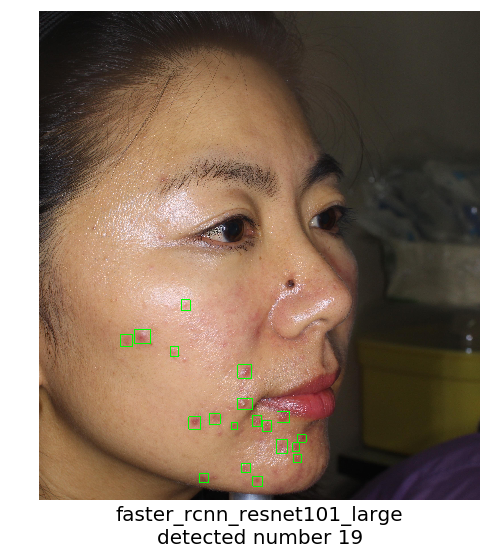

(array([0.9999988 , 0.99999833, 0.99999666, 0.99999595, 0.99999547,
        0.99999535, 0.99999213, 0.9999894 , 0.99998736, 0.9999869 ,
        0.9999752 , 0.9999409 , 0.9999069 , 0.9998821 , 0.9997944 ,
        0.9997756 , 0.9996892 , 0.999482  , 0.99646384], dtype=float32),
 array([[0.72378176, 0.45085698, 0.75126207, 0.4821713 ],
        [0.6521976 , 0.21610324, 0.6802693 , 0.25313586],
        [0.81942713, 0.5395605 , 0.8422039 , 0.5683882 ],
        [0.92579806, 0.45812303, 0.9432966 , 0.47865647],
        [0.8418621 , 0.43545324, 0.8568901 , 0.45081335],
        [0.83036774, 0.33958003, 0.8554079 , 0.3660811 ],
        [0.6873268 , 0.2967579 , 0.70782506, 0.31567454],
        [0.59149086, 0.32238215, 0.6130363 , 0.34301957],
        [0.79271764, 0.45074382, 0.81519437, 0.48423404],
        [0.90661633, 0.57637155, 0.9235128 , 0.59511244],
        [0.86674505, 0.5853746 , 0.8816281 , 0.6053191 ],
        [0.6610295 , 0.18440698, 0.68626636, 0.2122339 ],
        [0.8235477 , 0.3863

In [24]:
detect_and_draw(all_fi[1000],show=True,title='faster_rcnn_resnet101_large',savefig=False)

levle0_1.jpg
(3456, 3112, 3)
detection cost 4.4373674392700195 second(s)


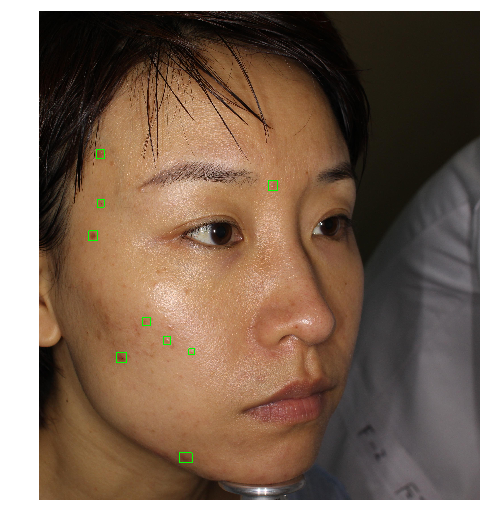

In [25]:
hehe_scores, hehe_boxes, acne_num = detect_and_draw(all_fi[0], min_score_thresh=0.75, show=True)

In [26]:
hehe_boxes

array([[0.9029694 , 0.31825215, 0.9234041 , 0.3469738 ],
       [0.34827062, 0.5191749 , 0.3681293 , 0.54061216],
       [0.6994471 , 0.17523138, 0.7195568 , 0.19919455],
       [0.2843477 , 0.13097547, 0.30380887, 0.14925751],
       [0.3862494 , 0.13243431, 0.4018483 , 0.147365  ],
       [0.6278425 , 0.23503627, 0.6440611 , 0.2525315 ],
       [0.45064035, 0.11314552, 0.4700805 , 0.13233544],
       [0.69132537, 0.3396494 , 0.7033291 , 0.35241395],
       [0.66613907, 0.28241605, 0.682134  , 0.2977944 ]], dtype=float32)

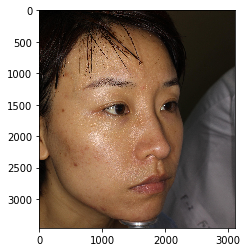

In [27]:
img_test = cv2.imread(all_fi[0])[...,::-1]
plt.imshow(img_test)

In [ ]:
fl_w, fl_h = img_test.shape[:2]
fl_w, fl_h

In [ ]:
mask_acne = np.zeros(shape=(fl_w, fl_h), dtype=np.uint8)
img_with_boxes = img_test.copy()
for ymin, xmin, ymax, xmax in hehe_boxes:
    ymin, xmin, ymax, xmax = int(round(ymin*fl_w)), int(round(xmin*fl_h)), int(round(ymax*fl_w)), int(round(xmax*fl_h))
    mask_acne[ymin:ymax, xmin:xmax] = 1
    cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), (0, 255, 0), 10)

In [ ]:
mask_acne.shape

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11,5))
ax1.imshow(img_with_boxes)
ax2.imshow(mask_acne,cmap='gray')
plt.show()

In [ ]:
_, labels = cv2.connectedComponents(mask_acne, 1, 4)
labels = np.unique(labels)
acne_num = max(0, len(labels) - 1)
acne_num

In [28]:
detect(all_fi[0], min_score_thresh=[0.25,0.5,0.75,0.9])

levle0_1.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.337296485900879 second(s)


({0.25: array([0.9999962 , 0.9999926 , 0.9999776 , 0.9999279 , 0.9775637 ,
         0.972889  , 0.8996668 , 0.84417576, 0.7848131 ], dtype=float32),
  0.5: array([0.9999962 , 0.9999926 , 0.9999776 , 0.9999279 , 0.9775637 ,
         0.972889  , 0.8996668 , 0.84417576, 0.7848131 ], dtype=float32),
  0.75: array([0.9999962 , 0.9999926 , 0.9999776 , 0.9999279 , 0.9775637 ,
         0.972889  , 0.8996668 , 0.84417576, 0.7848131 ], dtype=float32),
  0.9: array([0.9999962, 0.9999926, 0.9999776, 0.9999279, 0.9775637, 0.972889 ],
        dtype=float32)},
 {0.25: array([[0.9029694 , 0.31825215, 0.9234041 , 0.3469738 ],
         [0.34827062, 0.5191749 , 0.3681293 , 0.54061216],
         [0.6994471 , 0.17523138, 0.7195568 , 0.19919455],
         [0.2843477 , 0.13097547, 0.30380887, 0.14925751],
         [0.3862494 , 0.13243431, 0.4018483 , 0.147365  ],
         [0.6278425 , 0.23503627, 0.6440611 , 0.2525315 ],
         [0.45064035, 0.11314552, 0.4700805 , 0.13233544],
         [0.69132537, 0.33964

In [29]:
df_ann = pd.read_csv('/export/servers/data/acne/annotations_comprehensive.csv')

In [30]:
df_ann['img_ori_name'] = df_ann['img_filename'].apply(lambda fn:fn.replace("level", "levle"))

In [31]:
df_ann = df_ann[['img_ori_name','acne_lesion_num','severity_level']]

In [32]:
df_ann = df_ann[df_ann['img_ori_name'].isin([os.path.basename(item) for item in all_fi])].reset_index(drop=True)

In [33]:
df_ann

,img_ori_name,acne_lesion_num,severity_level
0,levle0_451.jpg,2,0
1,levle0_498.jpg,1,0
2,levle0_485.jpg,3,0
3,levle0_218.jpg,2,0
4,levle1_344.jpg,4,0
5,levle0_302.jpg,2,0
6,levle1_413.jpg,4,0
7,levle0_210.jpg,2,0
8,levle0_83.jpg,1,0
9,levle0_319.jpg,2,0


In [34]:
to_test_images = df_ann['img_ori_name'].values.tolist()

In [35]:
len(to_test_images)

1222

In [36]:
res_90 = {fn:0 for fn in to_test_images}
res_75 = {fn:0 for fn in to_test_images}
res_50 = {fn:0 for fn in to_test_images}
res_25 = {fn:0 for fn in to_test_images}

In [37]:
for fn in to_test_images:
    fp = os.path.join(filtered_image_path, fn)
    _, _, num = detect(fp, min_score_thresh=[0.25,0.5,0.75,0.9])
#     scores,_ = detect_and_draw(fp, min_score_thresh=0.75, show=False)
    res_90[fn] = num[0.9]
    res_75[fn] = num[0.75]
    res_50[fn] = num[0.5]
    res_25[fn] = num[0.25]

levle0_451.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.346157073974609 second(s)
levle0_498.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.21662712097168 second(s)
levle0_485.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.289858818054199 second(s)
levle0_218.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.223793029785156 second(s)
levle1_344.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.201104640960693 second(s)
levle0_302.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.24861216545105 second(s)
levle1_413.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.2420654296875 second(s)
levle0_210.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.435498476028442 second(s)
levle0_83.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 5.159670829772949 second(s)
levle0_319.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.383996486663818 second(s)
levle0_64.jpg
4

levle0_354.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.363550424575806 second(s)
levle0_142.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.7839648723602295 second(s)
levle0_16.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.625929832458496 second(s)
levle0_449.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.338212251663208 second(s)
levle0_335.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.452321529388428 second(s)
levle0_377.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.328189373016357 second(s)
levle0_389.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.353962659835815 second(s)
levle0_240.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.3046369552612305 second(s)
levle0_467.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.83760929107666 second(s)
levle0_436.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.291159152984619 second(s)
levle0_144

levle1_91.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.50749397277832 second(s)
levle1_82.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.654626846313477 second(s)
levle1_576.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.398046970367432 second(s)
levle1_515.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.35504150390625 second(s)
levle1_472.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.446081638336182 second(s)
levle1_615.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.676761865615845 second(s)
levle1_192.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.553943157196045 second(s)
levle2_86.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.545052528381348 second(s)
levle1_385.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.357645511627197 second(s)
levle1_63.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 5.063834190368652 second(s)
levle1_320.jpg
3

levle0_385.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.8528478145599365 second(s)
levle0_267.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.909045219421387 second(s)
levle0_216.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 6.562863349914551 second(s)
levle0_89.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.747849464416504 second(s)
levle0_190.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 5.202855587005615 second(s)
levle0_172.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.7349090576171875 second(s)
levle0_160.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.326768636703491 second(s)
levle0_516.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.313307046890259 second(s)
levle0_45.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.254721164703369 second(s)
levle0_81.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.815231561660767 second(s)
levle0_306.

levle0_316.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.919742584228516 second(s)
levle0_399.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.5519890785217285 second(s)
levle0_330.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.3126749992370605 second(s)
levle1_559.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.586889266967773 second(s)
levle0_157.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.315348386764526 second(s)
levle1_157.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.351668834686279 second(s)
levle1_319.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.560511350631714 second(s)
levle1_612.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.301775932312012 second(s)
levle1_297.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.594983339309692 second(s)
levle1_627.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.8216047286987305 second(s)
levle1_

levle1_274.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 6.037777662277222 second(s)
levle1_231.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 5.940544366836548 second(s)
levle1_599.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 5.773309230804443 second(s)
levle1_185.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 5.499120473861694 second(s)
levle1_287.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.797940254211426 second(s)
levle1_384.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.846941709518433 second(s)
levle1_364.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.795537710189819 second(s)
levle1_250.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.631304979324341 second(s)
levle1_251.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.088028907775879 second(s)
levle1_372.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.032543659210205 second(s)
levle1_218

levle0_188.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.1926820278167725 second(s)
levle0_120.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.19710373878479 second(s)
levle0_40.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.191838979721069 second(s)
levle0_320.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.229893445968628 second(s)
levle0_261.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.174573659896851 second(s)
levle0_1.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.205275058746338 second(s)
levle0_315.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.185970783233643 second(s)
levle0_137.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.2124738693237305 second(s)
levle1_368.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.204254150390625 second(s)
levle1_198.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.17817759513855 second(s)
levle0_291.jp

levle0_321.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.150489568710327 second(s)
levle0_386.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.205028057098389 second(s)
levle0_171.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.152724981307983 second(s)
levle0_290.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.159289121627808 second(s)
levle0_327.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.152950763702393 second(s)
levle0_419.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.149122476577759 second(s)
levle0_243.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.174315929412842 second(s)
levle1_485.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.158512830734253 second(s)
levle1_462.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.2198216915130615 second(s)
levle1_458.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.229532480239868 second(s)
levle1_17

levle1_636.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.1909263134002686 second(s)
levle1_517.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.195701360702515 second(s)
levle1_538.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.191014051437378 second(s)
levle1_81.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.373252630233765 second(s)
levle1_557.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.255498170852661 second(s)
levle1_254.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.155790090560913 second(s)
levle1_431.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.197698593139648 second(s)
levle1_408.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.20411229133606 second(s)
levle1_370.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.175352573394775 second(s)
levle1_139.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.227450847625732 second(s)
levle1_220.

levle0_448.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 6.11019492149353 second(s)
levle0_206.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 6.152125358581543 second(s)
levle0_283.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.175503253936768 second(s)
levle0_358.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.147337198257446 second(s)
levle0_35.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.154783248901367 second(s)
levle0_528.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.150181770324707 second(s)
levle0_63.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.319532155990601 second(s)
levle0_183.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.173896551132202 second(s)
levle0_421.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.190293073654175 second(s)
levle0_207.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.213989973068237 second(s)
levle0_249.jp

levle1_236.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.157341480255127 second(s)
levle1_280.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.210886716842651 second(s)
levle1_566.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.20905613899231 second(s)
levle1_314.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.2218403816223145 second(s)
levle1_433.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.1446216106414795 second(s)
levle1_512.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.1659934520721436 second(s)
levle1_111.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.326239824295044 second(s)
levle1_93.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.330374240875244 second(s)
levle1_456.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.189953327178955 second(s)
levle1_633.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.154533624649048 second(s)
levle1_16

levle1_79.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.339829444885254 second(s)
levle1_107.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.35579514503479 second(s)
levle1_313.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.194402694702148 second(s)
levle1_587.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.156378507614136 second(s)
levle1_347.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.160208463668823 second(s)
levle1_291.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.167113780975342 second(s)
levle1_206.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.182857513427734 second(s)
levle1_56.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.178242206573486 second(s)
levle1_288.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.2137205600738525 second(s)
levle1_113.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 4.352695465087891 second(s)
levle1_245.j

levle0_303.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.202440977096558 second(s)
levle0_15.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.204464912414551 second(s)
levle0_52.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.237440347671509 second(s)
levle0_123.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.18795371055603 second(s)
levle0_337.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.239468812942505 second(s)
levle0_429.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.197087526321411 second(s)
levle0_416.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.2091288566589355 second(s)
levle0_38.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.21332859992981 second(s)
levle0_150.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.217882394790649 second(s)
levle0_420.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.203194856643677 second(s)
levle0_376.jpg

levle1_312.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.123530149459839 second(s)
levle1_171.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.1271891593933105 second(s)
levle1_484.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.138708591461182 second(s)
levle1_226.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.167728900909424 second(s)
levle1_172.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.124052286148071 second(s)
levle1_522.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.159464597702026 second(s)
levle1_550.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.116690635681152 second(s)
levle1_324.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.118837356567383 second(s)
levle1_593.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.117992401123047 second(s)
levle1_391.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.119445085525513 second(s)
levle1_16

levle1_296.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.09269905090332 second(s)
levle1_584.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.070008277893066 second(s)
levle1_36.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.08197546005249 second(s)
levle1_591.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.073679685592651 second(s)
levle1_534.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.082788705825806 second(s)
levle1_329.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.082083463668823 second(s)
levle1_237.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.119063854217529 second(s)
levle1_141.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.088764667510986 second(s)
levle1_629.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.089752674102783 second(s)
levle1_396.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 4.087048530578613 second(s)
levle1_467.jp

In [38]:
df_ann['res25_num'] = df_ann['img_ori_name'].apply(lambda n:res_25[n])
df_ann['res50_num'] = df_ann['img_ori_name'].apply(lambda n:res_50[n])
df_ann['res75_num'] = df_ann['img_ori_name'].apply(lambda n:res_75[n])
df_ann['res90_num'] = df_ann['img_ori_name'].apply(lambda n:res_90[n])

In [39]:
df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num
0,levle0_451.jpg,2,0,3,3,3,3
1,levle0_498.jpg,1,0,1,1,1,1
2,levle0_485.jpg,3,0,3,3,3,3
3,levle0_218.jpg,2,0,6,6,6,6
4,levle1_344.jpg,4,0,1,1,1,1


In [40]:
df_ann["bias25"] = df_ann.apply(lambda row: row["res25_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias50"] = df_ann.apply(lambda row: row["res50_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias75"] = df_ann.apply(lambda row: row["res75_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias90"] = df_ann.apply(lambda row: row["res90_num"]-row["acne_lesion_num"], axis=1)

df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90
0,levle0_451.jpg,2,0,3,3,3,3,1,1,1,1
1,levle0_498.jpg,1,0,1,1,1,1,0,0,0,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0
3,levle0_218.jpg,2,0,6,6,6,6,4,4,4,4
4,levle1_344.jpg,4,0,1,1,1,1,-3,-3,-3,-3


In [41]:
df_ann.describe()

,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90
count,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000
mean,9.083470,0.762684,8.924714,8.716039,8.506547,8.247954,-0.158756,-0.367430,-0.576923,-0.835516
std,10.545308,0.738093,8.190158,7.930620,7.691186,7.380157,6.792177,6.913531,7.028914,7.200074
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-59.000000,-59.000000,-59.000000,-61.000000
25%,2.000000,0.000000,3.000000,3.000000,3.000000,3.000000,-1.000000,-1.000000,-2.000000,-2.000000
50%,6.000000,1.000000,7.000000,7.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,1.000000,12.000000,12.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000
max,65.000000,3.000000,61.000000,59.000000,57.000000,52.000000,20.000000,19.000000,19.000000,19.000000


In [42]:
mae_90 = np.mean(np.abs(df_ann['bias90'].values))
mae_25 = np.mean(np.abs(df_ann['bias25'].values))
mae_50 = np.mean(np.abs(df_ann['bias50'].values))
mae_75 = np.mean(np.abs(df_ann['bias75'].values))

In [45]:
mae_25,mae_50,mae_75, mae_90

(3.4877250409165304, 3.5, 3.5458265139116203, 3.5981996726677576)

In [46]:
rmse_90 = np.sqrt(np.mean((df_ann['bias90'].values)**2))
rmse_25 = np.sqrt(np.mean((df_ann['bias25'].values)**2))
rmse_50 = np.sqrt(np.mean((df_ann['bias50'].values)**2))
rmse_75 = np.sqrt(np.mean((df_ann['bias75'].values)**2))

In [47]:
rmse_25,rmse_50,rmse_75,rmse_90

(6.791252677497987, 6.920462317697498, 7.0496833976106075, 7.245462488866928)

In [48]:
df_ann['res25_lv'] = df_ann['res25_num'].apply(lambda n: to_severity(n))
df_ann['res50_lv'] = df_ann['res50_num'].apply(lambda n: to_severity(n))
df_ann['res75_lv'] = df_ann['res75_num'].apply(lambda n: to_severity(n))
df_ann['res90_lv'] = df_ann['res90_num'].apply(lambda n: to_severity(n))

In [49]:
df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res25_lv,res50_lv,res75_lv,res90_lv
0,levle0_451.jpg,2,0,3,3,3,3,1,1,1,1,0,0,0,0
1,levle0_498.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,6,6,6,4,4,4,4,1,1,1,1
4,levle1_344.jpg,4,0,1,1,1,1,-3,-3,-3,-3,0,0,0,0


In [50]:
df_ann.describe()

,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res25_lv,res50_lv,res75_lv,res90_lv
count,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000
mean,9.083470,0.762684,8.924714,8.716039,8.506547,8.247954,-0.158756,-0.367430,-0.576923,-0.835516,0.657938,0.642390,0.627660,0.613748
std,10.545308,0.738093,8.190158,7.930620,7.691186,7.380157,6.792177,6.913531,7.028914,7.200074,0.649461,0.637823,0.624103,0.616248
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-59.000000,-59.000000,-59.000000,-61.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,3.000000,3.000000,3.000000,-1.000000,-1.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1.000000,7.000000,7.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,10.000000,1.000000,12.000000,12.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,65.000000,3.000000,61.000000,59.000000,57.000000,52.000000,20.000000,19.000000,19.000000,19.000000,3.000000,3.000000,3.000000,3.000000


In [51]:
stats_by_lv = {}
for lv, df_lv in df_ann.groupby("severity_level"):
    lv_mae_90 = np.mean(np.abs(df_lv['bias90'].values))
    lv_mae_25 = np.mean(np.abs(df_lv['bias25'].values))
    lv_mae_50 = np.mean(np.abs(df_lv['bias50'].values))
    lv_mae_75 = np.mean(np.abs(df_lv['bias75'].values))
    lv_rmse_90 = np.sqrt(np.mean(np.abs(df_lv['bias90'].values)**2))
    lv_rmse_25 = np.sqrt(np.mean(np.abs(df_lv['bias25'].values)**2))
    lv_rmse_50 = np.sqrt(np.mean(np.abs(df_lv['bias50'].values)**2))
    lv_rmse_75 = np.sqrt(np.mean(np.abs(df_lv['bias75'].values)**2))
    lv_mean_90 = np.mean(df_lv['bias90'].values)
    lv_mean_25 = np.mean(df_lv['bias25'].values)
    lv_mean_50 = np.mean(df_lv['bias50'].values)
    lv_mean_75 = np.mean(df_lv['bias75'].values)
    lv_std_90 = np.std(df_lv['bias90'].values)
    lv_std_25 = np.std(df_lv['bias25'].values)
    lv_std_50 = np.std(df_lv['bias50'].values)
    lv_std_75 = np.std(df_lv['bias75'].values)
    stats_by_lv["level{}".format(lv)] = {"mae90":lv_mae_90, "mae25":lv_mae_25, "mae50":lv_mae_50, "mae75":lv_mae_75, "rmse90":lv_rmse_90, "rmse25":lv_rmse_25, "rmse50":lv_rmse_50, "rmse75":lv_rmse_75, "mean90":lv_mean_90, "mean25":lv_mean_25, "mean50":lv_mean_50, "mean75":lv_mean_75, "std90":lv_std_90, "std25":lv_std_25, "std50":lv_std_50, "std75":lv_std_75}

In [52]:
stats_by_lv

{'level0': {'mae90': 1.1431535269709543,
  'mae25': 1.2634854771784232,
  'mae50': 1.2282157676348548,
  'mae75': 1.1929460580912863,
  'rmse90': 1.7528873631479627,
  'rmse25': 1.9319330074379433,
  'rmse50': 1.8824368421623845,
  'rmse75': 1.8338676450112443,
  'mean90': 0.5124481327800829,
  'mean25': 0.6908713692946058,
  'mean50': 0.6390041493775933,
  'mean75': 0.5871369294605809,
  'std90': 1.6763087481409933,
  'std25': 1.8041790089448475,
  'std50': 1.7706615040172158,
  'std75': 1.7373372630213995},
 'level1': {'mae90': 3.2785467128027683,
  'mae25': 3.368512110726644,
  'mae50': 3.328719723183391,
  'mae75': 3.2975778546712804,
  'rmse90': 4.31200946259819,
  'rmse25': 4.5016336903787435,
  'rmse50': 4.412156845317453,
  'rmse75': 4.3569139263861665,
  'mean90': 0.8356401384083045,
  'mean25': 1.3131487889273357,
  'mean50': 1.1591695501730104,
  'mean75': 1.0207612456747406,
  'std90': 4.230263722821225,
  'std25': 4.305850222719273,
  'std50': 4.257165016960625,
  'std75':

In [53]:
np.unique(df_ann['severity_level'].values, return_counts=True)

(array([0, 1, 2, 3]), array([482, 578, 132,  30]))

In [54]:
df_ann[df_ann['severity_level']==3]

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res25_lv,res50_lv,res75_lv,res90_lv
237,levle3_80.jpg,57,3,43,41,38,36,-14,-16,-19,-21,2,2,2,2
238,levle3_36.jpg,52,3,23,22,21,20,-29,-30,-31,-32,2,2,2,1
239,levle3_144.jpg,58,3,13,11,9,9,-45,-47,-49,-49,1,1,1,1
240,levle3_97.jpg,64,3,31,27,26,26,-33,-37,-38,-38,2,2,2,2
481,levle3_94.jpg,53,3,61,59,57,52,8,6,4,-1,3,3,3,3
482,levle3_92.jpg,56,3,33,33,32,31,-23,-23,-24,-25,2,2,2,2
483,levle3_143.jpg,53,3,3,3,3,2,-50,-50,-50,-51,0,0,0,0
484,levle3_130.jpg,53,3,42,41,40,38,-11,-12,-13,-15,2,2,2,2
485,levle3_131.jpg,51,3,26,24,23,21,-25,-27,-28,-30,2,2,2,2
486,levle3_79.jpg,64,3,31,29,29,29,-33,-35,-35,-35,2,2,2,2


In [55]:
df_positive_examples = df_ann[df_ann["bias50"]==0]

df_positive_examples

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res25_lv,res50_lv,res75_lv,res90_lv
1,levle0_498.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
6,levle1_413.jpg,4,0,4,4,3,3,0,0,-1,-1,0,0,0,0
8,levle0_83.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
15,levle0_178.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
21,levle0_346.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
22,levle0_410.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
26,levle0_307.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
27,levle0_510.jpg,2,0,2,2,2,2,0,0,0,0,0,0,0,0
30,levle1_159.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0


In [ ]:
positive_examples = ["levle0_346.jpg", "levle0_488.jpg", "levle1_624.jpg", "levle1_540.jpg"]

In [ ]:
detect_and_draw(os.path.join(filtered_image_path, positive_examples[3]), show=True, min_score_thresh=0.5, title='ground truth number 15',savefig=True)

In [ ]:
monitoring_examples = ["levle1_361.jpg", "levle1_364.jpg", "levle1_362.jpg", "levle1_363.jpg"]

In [ ]:
df_ann[df_ann['img_ori_name'].isin(monitoring_examples)]

In [ ]:
_,_,_ = detect_and_draw(os.path.join(filtered_image_path, monitoring_examples[3]), show=True, min_score_thresh=0.5, title='ground truth number 6',savefig=True)

In [ ]:
testset_images = glob.glob("/export/servers/data/acne_article_data/test_set_images/*.jpg")

In [ ]:
testset_images

In [ ]:
df_ann[df_ann['img_ori_name'].isin(["levle3_142.jpg","levle3_130.jpg","levle3_132.jpg"])]

In [ ]:
detect_and_draw(testset_images[2],show=True,title='ground truth number 62',savefig=True)

In [ ]:
for img in testset_images:
    _,_,num = detect_and_draw(img, min_score_thresh=0.25, show=True)
    print(f"{num} acne lesions detected in {os.path.basename(img)}")

In [56]:
df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res25_lv,res50_lv,res75_lv,res90_lv
0,levle0_451.jpg,2,0,3,3,3,3,1,1,1,1,0,0,0,0
1,levle0_498.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,6,6,6,4,4,4,4,1,1,1,1
4,levle1_344.jpg,4,0,1,1,1,1,-3,-3,-3,-3,0,0,0,0


In [58]:
df_ann[["acne_lesion_num","res25_num","res50_num","res75_num","res90_num"]].corr()

,acne_lesion_num,res25_num,res50_num,res75_num,res90_num
acne_lesion_num,1.000000,0.765034,0.755112,0.745644,0.731305
res25_num,0.765034,1.000000,0.998187,0.994999,0.989850
res50_num,0.755112,0.998187,1.000000,0.997795,0.993743
res75_num,0.745644,0.994999,0.997795,1.000000,0.996940
res90_num,0.731305,0.989850,0.993743,0.996940,1.000000


In [59]:
df_low_severity = df_ann[df_ann["severity_level"].isin([0,1,2])]

df_low_severity

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res25_lv,res50_lv,res75_lv,res90_lv
0,levle0_451.jpg,2,0,3,3,3,3,1,1,1,1,0,0,0,0
1,levle0_498.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,6,6,6,4,4,4,4,1,1,1,1
4,levle1_344.jpg,4,0,1,1,1,1,-3,-3,-3,-3,0,0,0,0
5,levle0_302.jpg,2,0,1,1,1,1,-1,-1,-1,-1,0,0,0,0
6,levle1_413.jpg,4,0,4,4,3,3,0,0,-1,-1,0,0,0,0
7,levle0_210.jpg,2,0,1,1,1,1,-1,-1,-1,-1,0,0,0,0
8,levle0_83.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
9,levle0_319.jpg,2,0,4,4,4,4,2,2,2,2,0,0,0,0


In [73]:
def plot_fit(threshold, save_name=None):
    polyn = np.poly1d(np.polyfit(df_ann['acne_lesion_num'],df_ann[f"res{threshold}_num"], 1))
    polyn_ls = np.poly1d(np.polyfit(df_low_severity['acne_lesion_num'],df_low_severity[f"res{threshold}_num"], 1))

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(df_ann['acne_lesion_num'].values,df_ann[f"res{threshold}_num"].values, s=8)
    # ax.set_xlim(0,65)
    # ax.set_ylim(0,65)
    ax.plot(np.arange(0,60,1),np.arange(0,60,1), color='red', linewidth=4, linestyle='solid', label="x=y")
    ax.plot(np.arange(0,65,1),polyn_ls(np.arange(0,65,1)), color='magenta', linewidth=4, linestyle='dashed', label="line fit partial")
    ax.plot(np.arange(0,65,1),polyn(np.arange(0,65,1)), color='orange', linewidth=4, linestyle='dashdot', label="line fit total")
    ax.legend(loc="best",fontsize=24)
    ax.set_xlabel("Truth",fontsize=24)
    ax.set_ylabel("Prediction",fontsize=24)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
    plt.title(f"Lesion Number Scatter Plot\nScore Threshold 0.{threshold}",fontsize=28)
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', transparent=True)

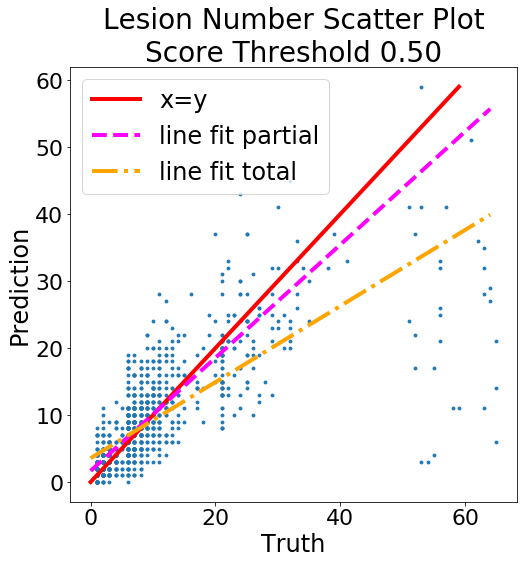

In [76]:
plot_fit(50, save_name="./scatter_plot_frcnn_resnet101_50.pdf")

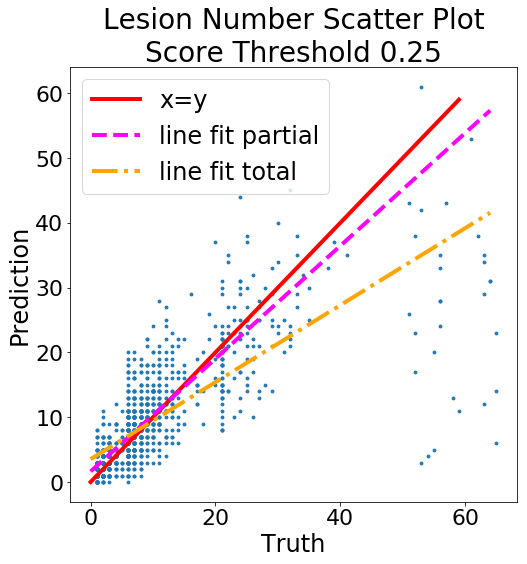

In [75]:
plot_fit(25)

In [62]:
from pycm import *

In [63]:
cm_90 = ConfusionMatrix(actual_vector=df_ann["severity_level"].values, predict_vector=df_ann["res90_lv"].values)
cm_25 = ConfusionMatrix(actual_vector=df_ann["severity_level"].values, predict_vector=df_ann["res25_lv"].values)
cm_50 = ConfusionMatrix(actual_vector=df_ann["severity_level"].values, predict_vector=df_ann["res50_lv"].values)
cm_75 = ConfusionMatrix(actual_vector=df_ann["severity_level"].values, predict_vector=df_ann["res75_lv"].values)

In [64]:
print(cm_90)

Predict   0         1         2         3         
Actual
0         439       43        0         0         

1         115       447       16        0         

2         0         80        52        0         

3         4         9         16        1         





Overall Statistics : 

95% CI                                                            (0.74476,0.79206)
ACC Macro                                                         0.88421
AUNP                                                              0.80243
AUNU                                                              0.71453
Bennett S                                                         0.69122
CBA                                                               0.49651
CSI                                                               0.32231
Chi-Squared                                                       1019.93978
Chi-Squared DF                                                    9
Conditional Entropy               

In [65]:
print(cm_25)

Predict   0         1         2         3         
Actual
0         434       48        0         0         

1         99        459       20        0         

2         0         56        76        0         

3         3         7         18        2         





Overall Statistics : 

95% CI                                                            (0.77195,0.81725)
ACC Macro                                                         0.8973
AUNP                                                              0.82747
AUNU                                                              0.74899
Bennett S                                                         0.72613
CBA                                                               0.56156
CSI                                                               0.40465
Chi-Squared                                                       1228.08608
Chi-Squared DF                                                    9
Conditional Entropy                

In [66]:
print(cm_50)

Predict   0         1         2         3         
Actual
0         435       47        0         0         

1         105       455       18        0         

2         0         66        66        0         

3         3         7         18        2         





Overall Statistics : 

95% CI                                                            (0.76089,0.80704)
ACC Macro                                                         0.89198
AUNP                                                              0.81735
AUNU                                                              0.73638
Bennett S                                                         0.71195
CBA                                                               0.53874
CSI                                                               0.37396
Chi-Squared                                                       1162.55967
Chi-Squared DF                                                    9
Conditional Entropy               

In [67]:
print(cm_75)

Predict   0         1         2         3         
Actual
0         436       46        0         0         

1         109       452       17        0         

2         0         76        56        0         

3         3         9         16        2         





Overall Statistics : 

95% CI                                                            (0.7507,0.79759)
ACC Macro                                                         0.88707
AUNP                                                              0.80748
AUNU                                                              0.72405
Bennett S                                                         0.69885
CBA                                                               0.51546
CSI                                                               0.3444
Chi-Squared                                                       1083.12974
Chi-Squared DF                                                    9
Conditional Entropy                 

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            save_name = "normalized_cm_{}.pdf".format(int(time.time()))
        else:
            title = 'Confusion matrix'
            save_name = "not_normalized_cm_{}.pdf".format(int(time.time()))
            
    if normalize:
        save_name = "normalized_cm_{}.pdf".format(int(time.time()))
    else:
        save_name = "not_normalized_cm_{}.pdf".format(int(time.time()))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     print((unique_labels(y_true.astype(int), y_pred.astype(int))).dtype)
#     classes = classes[unique_labels(y_true.astype(int), y_pred.astype(int))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label',
        )
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("True severity",fontsize=14)
    ax.set_ylabel("Predicted severity",fontsize=14)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", 
                    fontsize=18)
    fig.tight_layout()
    plt.savefig(save_name, bbox_inches='tight', transparent=True)
    
    return ax

Confusion matrix, without normalization


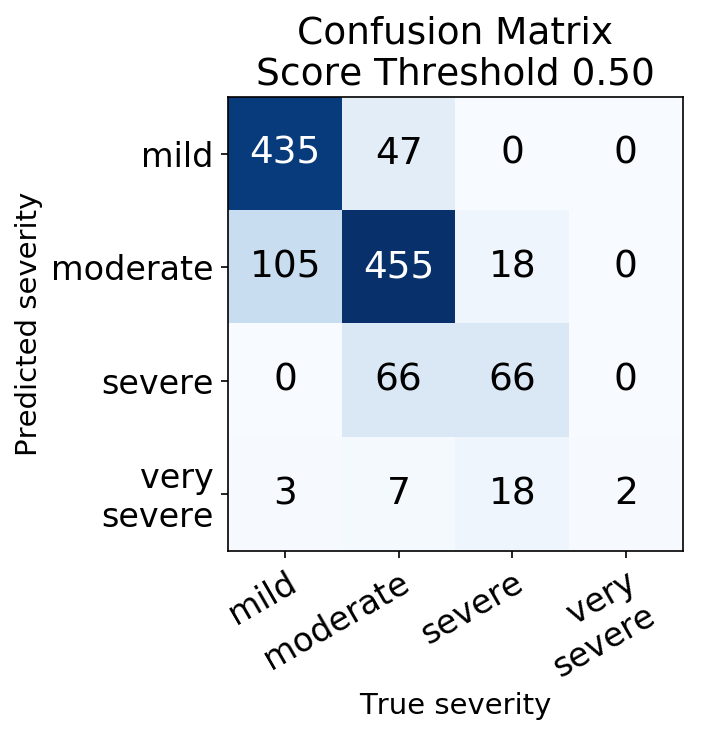

In [78]:
thre = 50

plot_confusion_matrix(df_ann["severity_level"].values, df_ann[f"res{thre}_lv"].values, classes=["mild", "moderate", "severe", "very\nsevere"], title=f"Confusion Matrix\nScore Threshold 0.{thre}")

Confusion matrix, without normalization


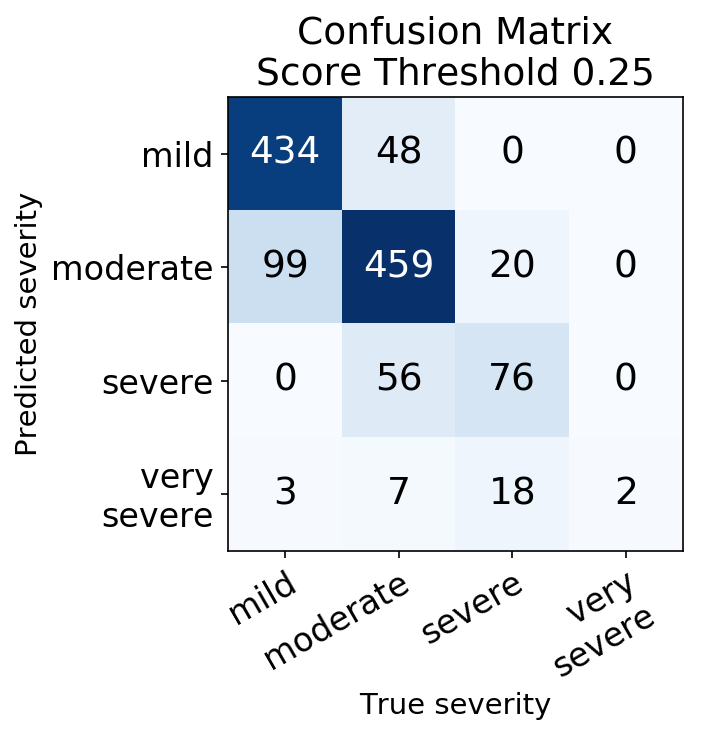

In [70]:
thre = 25

plot_confusion_matrix(df_ann["severity_level"].values, df_ann[f"res{thre}_lv"].values, classes=["mild", "moderate", "severe", "very\nsevere"], title=f"Confusion Matrix\nScore Threshold 0.{thre}")

In [ ]:
len(all_fi)

In [ ]:
[os.path.basename(item) for item in all_fi if os.path.basename(item) not in df_ann['img_ori_name'].values.tolist()]

In [ ]:
import sklearn

sklearn.__version__

In [ ]:
import matplotlib, pyforest
matplotlib.__version__, pyforest.__version__